In [21]:
import TurbPy as tb
from TurbPy.imports import *

In [22]:
# deck = 'KH_Lv1di/'
# deck = 'KH_new/'
# deck = 'KH_400ppc_200wci2/'
deck = 'KH_200ppc_200wci/'
# deck = 'KH_beta0.1/'
# deck = 'turb2/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

lx_de = info['Lx/de']
ly_de = info['Ly/de']

lx_di = info['Lx/di']
ly_di = info['Ly/di']

nx = int(info['nx'])
ny = int(info['ny'])

lxr_di = np.linspace(0, lx_di, nx)
lyr_di = np.linspace(0, ly_di, ny)

lxr_de = np.linspace(0, lx_de, nx)
lyr_de = np.linspace(0, ly_de, ny)

In [23]:
# t = 5295
# ds = tb.load_vars(dirs, t, 'electron')

t = times[1087]
ds = tb.load_vars(dirs, t, 'electron')
print(twci[1087])

150.12209160000003


In [24]:
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])

dex = ds['ex'] - np.mean(ds['ex'])
dey = ds['ey'] - np.mean(ds['ey'])
dez = ds['ez'] - np.mean(ds['ez'])

In [25]:
def flip2D(var):
  var_flip = np.flip(var, axis = 0)
  var_flip = np.flip(var_flip, axis = 1)
  var_per = np.concatenate((var, var_flip))
  return var_per

In [26]:
dsi = tb.load_vars(dirs, t, 'ion')
jz_per = flip2D(ds['jz'] + dsi['jz'])
jx = (ds['jx'] + dsi['jx'])
jy = (ds['jy'] + dsi['jy'])
jz = (ds['jz'] + dsi['jz'])
j = np.sqrt(jx**2 + jy**2 + jz**2)
j_per = flip2D(j)

In [27]:
# dbx_flip = np.flip(dbx, axis = 0)
# dbx_per = np.concatenate((dbx, dbx_flip))

# dby_flip = np.flip(dby, axis = 0)
# dby_per = np.concatenate((dby, dby_flip))

# dbz_flip = np.flip(dbz, axis = 0)
# dbz_per = np.concatenate((dbz, dbz_flip))


# dex_flip = np.flip(dex, axis = 0)
# dex_per = np.concatenate((dex, dex_flip))

# dey_flip = np.flip(dey, axis = 0)
# dey_per = np.concatenate((dey, dey_flip))

# dez_flip = np.flip(dez, axis = 0)
# dez_per = np.concatenate((dez, dez_flip))

# dsi = tb.load_vars(dirs, t, 'ion')

# jz_flip = np.flip(ds['jz'] + dsi['jz'], axis = 0)
# jz_per = np.concatenate((ds['jz'] + dsi['jz'], jz_flip))

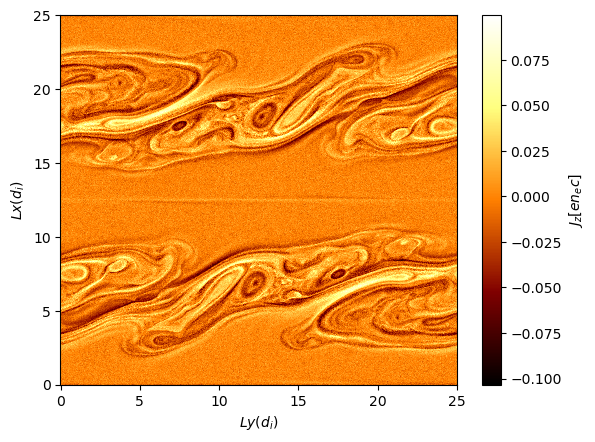

In [28]:
plt.pcolormesh(lyr_di, lyr_di, jz_per, cmap = 'afmhot')
plt.colorbar(label = r'$J_z \left[ e n_e c\right]$')
plt.ylabel(r'$Lx (d_i)$')
plt.xlabel(r'$Ly (d_i)$')
plt.savefig(figs + f'Jzp_{t}.jpg', dpi = 400)

In [29]:
def EnSpec2D(dbx, dby, dbz, kf = np.inf, numbins = 1, lx = 2 * np.pi, ly = 2 * np.pi):
    '''
    Calculation of omnidirectional magnetic/velocity energy spectrum using

    input: 
    dbx: np.array(floats); dbx = Bx(t) - <Bx(t)>  
    dby: np.array(floats); dby = By(t) - <By(t)>
    kf: float; value to filter energy spectrum
    numbins:int; number of bins to sum for each value k
    lx:float; size of box in x
    ly:float; size of box in y

    output:
    kbins: np.array(floats); binning of k values between kmin and kmax by numbins
    En : np.array(floats); dbx(k) + dby(k) summed between k + dk in kbins
    '''
    nx = dbx.shape[0]
    ny = dbx.shape[1]

    fdbx = np.fft.fftshift(np.fft.fftn(dbx))/(nx * ny)
    fdbx = np.abs(fdbx)**2/2
    fdbx = fdbx.flatten()

    fdby = np.fft.fftshift(np.fft.fftn(dby))/(nx * ny)
    fdby = np.abs(fdby)**2/2
    fdby = fdby.flatten()

    fdbz = np.fft.fftshift(np.fft.fftn(dbz))/(nx * ny)
    fdbz = np.abs(fdbz)**2/2
    fdbz = fdbz.flatten()

    kfreqx = nf.fftshift(nf.fftfreq(nx))* 2 * np.pi * (nx/lx)
    kfreqy = nf.fftshift(nf.fftfreq(ny))* 2 * np.pi * (ny/ly)
    kfreq2D = np.meshgrid(kfreqx, kfreqy) 
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    
    sort_ind = np.argsort(knrm)
    knrm_sort = knrm[sort_ind]
    fdbx_sort = fdbx[sort_ind]
    fdby_sort = fdby[sort_ind]
    fdbz_sort = fdbz[sort_ind]
    kmin = np.sqrt((2 * np.pi/lx)**2 + (2 * np.pi/ly)**2)
    kbins = np.linspace(0, knrm_sort[-1], numbins)
    fdbx_sum = np.zeros(len(kbins))
    fdby_sum = np.zeros(len(kbins))
    fdbz_sum = np.zeros(len(kbins))
    k_len = int(len(knrm_sort))
    kbin_len = int(len(kbins))
    iter = int(k_len/kbin_len)
    print(iter)
    for i in np.arange(0,len(kbins)):
        if kbins[i] < kf:
            print(kbins[i * iter: (i + 1) * iter])
            # fdbx_sum[i] = np.sum(fdbx_sort[(i * iter) : ((i + 1)* iter)])
            # fdby_sum[i] = np.sum(fdby_sort[(i * iter) : ((i + 1)* iter)])
            # fdbz_sum[i] = np.sum(fdbz_sort[(i * iter) : ((i + 1)* iter)])
        else :
            fdbx_sum[i] = 0
            fdby_sum[i] = 0
            fdbz_sum[i] = 0
    En = fdbx_sum + fdby_sum + fdbz_sum
    print(knrm_sort)
    return kbins,  En


In [30]:
dbx_per = flip2D(dbx)
dby_per = flip2D(dby)
dbz_per = flip2D(dbz)

In [44]:
# k, fft = tb.EnSpec2D(dbx, dby, dbz  numbins = 10 * nx, lx = lx, ly = ly)
# k, fft = EnSpec2D(dbx_per, dby_per, dbz_per, numbins = 350, lx = lx_de, ly = lx_de)
# snaps = [363, 507, 652, 1087]

t = times[100]
ds = tb.load_vars(dirs, t, 'electron')
print(twci[1087])
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])
dbx_per = flip2D(dbx)
dby_per = flip2D(dby)
dbz_per = flip2D(dbz)
k0, fft0 = tb.EbSpec2D(dbx_per, dby_per, dbz_per, lx = lx_de, ly = ly_de)

t = times[363]
ds = tb.load_vars(dirs, t, 'electron')
print(twci[1087])
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])
dbx_per = flip2D(dbx)
dby_per = flip2D(dby)
dbz_per = flip2D(dbz)
k, fft = tb.EbSpec2D(dbx_per, dby_per, dbz_per, lx = lx_de, ly = ly_de)


t = times[507]
ds = tb.load_vars(dirs, t, 'electron')
print(twci[1087])
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])
dbx_per = flip2D(dbx)
dby_per = flip2D(dby)
dbz_per = flip2D(dbz)
k2, fft2 = tb.EbSpec2D(dbx_per, dby_per, dbz_per, lx = lx_de, ly = ly_de)


t = times[652]
ds = tb.load_vars(dirs, t, 'electron')
print(twci[1087])
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])
dbx_per = flip2D(dbx)
dby_per = flip2D(dby)
dbz_per = flip2D(dbz)
k3, fft3 = tb.EbSpec2D(dbx_per, dby_per, dbz_per, lx = lx_de, ly = ly_de)

t = times[1087]
ds = tb.load_vars(dirs, t, 'electron')
print(twci[1087])
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])
dbx_per = flip2D(dbx)
dby_per = flip2D(dby)
dbz_per = flip2D(dbz)
k4, fft4 = tb.EbSpec2D(dbx_per, dby_per, dbz_per, lx = lx_de, ly = ly_de)

150.12209160000003
150.12209160000003
150.12209160000003
150.12209160000003
150.12209160000003


In [41]:
print(len(k2))

710


In [42]:
print(jz)

[[ 2.74389633e-04  2.36662431e-03 -6.10174751e-03 ... -2.64162663e-02
  -2.09037587e-02 -1.71446223e-02]
 [-7.75065413e-03 -8.53121374e-03 -5.24286972e-03 ... -8.48809909e-03
  -8.46577063e-03 -2.19369922e-02]
 [-8.60458892e-03 -1.12344455e-02  1.46965880e-03 ... -8.70059337e-03
  -1.15833683e-02 -1.99393500e-02]
 ...
 [-7.42017641e-04  6.05996326e-03  7.75906118e-03 ...  7.05413613e-03
   9.66376625e-03  1.04128113e-02]
 [-4.83776676e-05 -1.42468431e-03  8.99340212e-03 ...  6.78250520e-03
   1.01039698e-02  7.95964152e-03]
 [ 2.68071285e-03  3.93404067e-03  2.64397776e-03 ...  1.06111774e-02
   5.77484397e-03 -7.34115392e-03]]


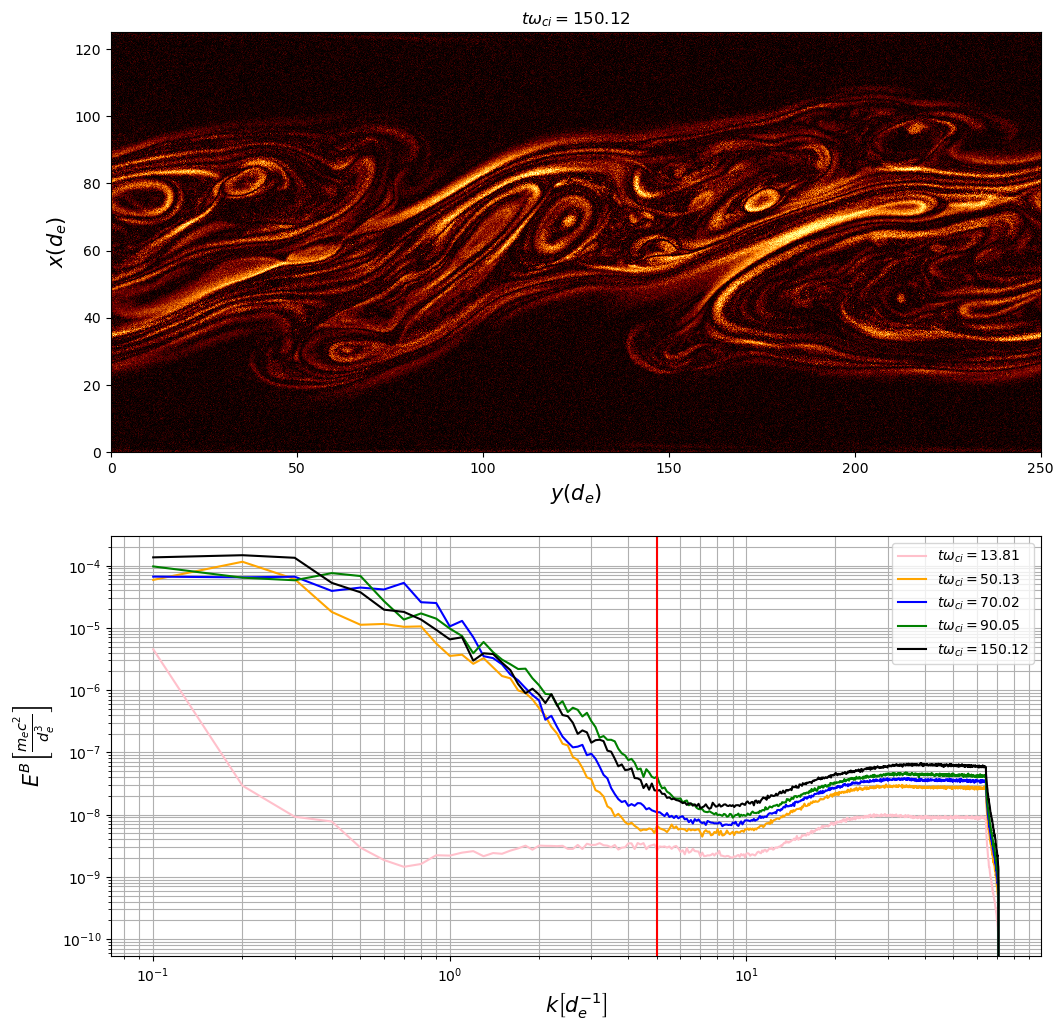

In [57]:
fig, ax1 = plt.subplots(2, 1, figsize = (12, 12))


cm1 = ax1[0].pcolormesh(lyr_de, lxr_de, np.abs(jz), cmap = 'afmhot', vmin = 0, vmax = 0.1)
ax1[0].set_xlabel(r'$y(d_e)$', size = 15)
ax1[0].set_ylabel(r'$x(d_e)$', size = 15)
ax1[0].set_title(r'$t \omega_{ci} = $'f'{np.round(twci[1087],2)}')
# fig.colorbar(cm1, label = '|J|')

ax1[1].loglog(k0[1:], fft0[1:], color = 'pink' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}')
ax1[1].loglog(k[1:], fft[1:], color = 'orange', label = r'$t \omega_{ci} = $'f'{ np.round(twci[363] ,2)}')
ax1[1].loglog(k2[1:], fft2[1:], color = 'blue', label = r'$t \omega_{ci} = $'f'{ np.round(twci[507] ,2)}')
ax1[1].loglog(k3[1:], fft3[1:], color = 'green', label = r'$t \omega_{ci} =$'f'{np.round(twci[652] ,2)}')
ax1[1].loglog(k4[1:], fft4[1:], color = 'black', label = r'$t \omega_{ci} =$'f'{np.round(twci[1087],2)}')
ax1[1].axvline(5, color = 'red')
ax1[1].set_ylabel(r'$E^B \left[ \frac{m_e c^2}{d_e^3}  \right]$', size  = 15)
ax1[1].set_xlabel(r'$k  \left[ d_e^{-1}    \right]$', size = 15)
ax1[1].grid(which = 'both')
ax1[1].legend(loc = 'upper right')
fig.savefig(figs + f'spectrum_twci.jpg', dpi = 400)